# Clonotypes

A clonotype is defined as the set of T- or B-cells sharing a common ancestor, i.e., they descent from an unmutated ancestral cell (immature adaptive cell) and therefore sharing and ancestry linage. Because of this phenomenon, it is asumed that IRs from those related adaptive cells share similar biological functions and recognize the same epitopes.

The clonotypes are recognized mainly detecting the similarity or identity of the nucleotide sequence of the CDR3 region for both chains, VJ and VDJ. 

Let's first load the libraries and the annData with the pre-processed IRs to run the clonotype detection.

In [1]:
import warnings

warnings.filterwarnings(
    "ignore",
    ".*IProgress not found*",
)
warnings.simplefilter(action="ignore", category=FutureWarning)

import scanpy as sc
import scirpy as ir
import pandas as pd
import numpy as np
import seaborn as sb

warnings.simplefilter(action="ignore", category=pd.errors.DtypeWarning)

In [2]:
sc.logging.print_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.8.0
scanpy      1.8.2
sinfo       0.3.4
-----
Levenshtein                 NA
PIL                         8.4.0
adjustText                  NA
airr                        1.3.1
anyio                       NA
asciitree                   NA
attr                        21.2.0
babel                       2.9.1
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      1.0.9
certifi                     2021.10.08
cffi               

In [2]:
path_data = "/home/icb/juan.henao/BestPracticeStart/data"

path_gex = f"{path_data}/TCR_filtered.h5ad"
adata = sc.read(path_gex)

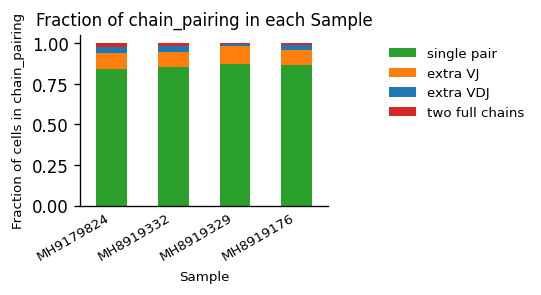

In [114]:
# Downsampling

adata = adata[
    adata.obs["patient_id"].isin(["COVID-014", "COVID-045", "COVID-066", "COVID-067"])
]
# adata[adata.obs['Status'] == 'Healthy'].obs['patient_id']
_ = ir.pl.group_abundance(
    adata, groupby="Sample", target_col="chain_pairing", normalize=True
)

# Clonotype definition

First, it is necessary to compute a distance of similarity/identity between the different unique nucleotide or amino acid sequences for both chains, VJ and VDJ. The distance matrix is located at adata.uns and is used to match cells 

In [ ]:
ir.pp.ir_dist(
    adata,
    metric="alignment",
    sequence="aa",
    cutoff=15,
)

  0%|          | 0/4137126 [00:00<?, ?it/s]

In [10]:
# Using the previous calculated distances, this function identifies clusters of similar sequences (a.k.a. clonotypes)

ir.tl.define_clonotype_clusters(
    adata, sequence="aa", metric="alignment", receptor_arms="all", dual_ir="any"
)

  0%|          | 0/8936 [00:00<?, ?it/s]

In [11]:
# This function use the previous results in the clonotype identification to allow the visualization of them
# as networks

ir.tl.clonotype_network(adata, min_cells=3, sequence="aa", metric="alignment")

... storing 'cc_aa_alignment' as categorical


<AxesSubplot:>

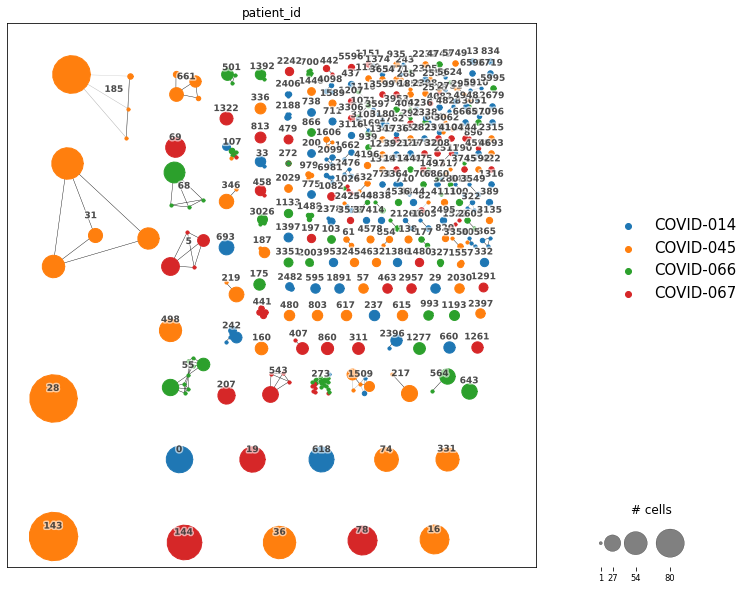

In [15]:
# Plotting the clonotypes as networks

# Public clonotype: Term to referer a clonotype present in multiple samples, e.g., the clonotype '0'
# Private clonotype: Term to refer a clonotype present exclusively in a specific sample, e.g., clonotype '10982'

ir.pl.clonotype_network(
    adata,
    color="patient_id",
    base_size=10,
    label_fontsize=9,
    panel_size=(10, 10),
    legend_fontsize=15,
)

In [16]:
# Clonotype names as strings
adata.obs["cc_aa_alignment"] = adata.obs["cc_aa_alignment"].astype("str")

In [19]:
# Example of the information necessary to perform further analysis
# The first two columns show the CDR3-alpha region
# The next two columns show the CDR3-beta region
# The next column shows the receptor subtype (T-cell receptor-alpha (TRA), T-cell receptor-beta (TRB))
# The last column shows the number of cells which that specific T-cell receptor were detected

adata.obs.loc[adata.obs["cc_aa_alignment"] == "107", :].groupby(
    [
        "IR_VJ_1_junction_aa",
        "IR_VJ_2_junction_aa",
        "IR_VDJ_1_junction_aa",
        "IR_VDJ_2_junction_aa",
        "receptor_subtype",
    ],
    observed=True,
).size().reset_index(name="n_cells")

,IR_VJ_1_junction_aa,IR_VJ_2_junction_aa,IR_VDJ_1_junction_aa,IR_VDJ_2_junction_aa,receptor_subtype,n_cells
0,CAANDYKLSF,CAVLDSNYQLIW,CASSPNSPGVNEQYF,CASSPGRDTGELFF,TRA+TRB,1


In [21]:
adata.obs.loc[adata.obs["cc_aa_alignment"] == "0", :].groupby(
    [
        "IR_VJ_1_junction_aa",
        "IR_VJ_2_junction_aa",
        "IR_VDJ_1_junction_aa",
        "IR_VDJ_2_junction_aa",
        "receptor_subtype",
    ],
    observed=True,
).size().reset_index(name="n_cells")

,IR_VJ_1_junction_aa,IR_VJ_2_junction_aa,IR_VDJ_1_junction_aa,IR_VDJ_2_junction_aa,receptor_subtype,n_cells


# Clonal expansion

In [22]:
ir.tl.clonal_expansion(adata)

<AxesSubplot:>

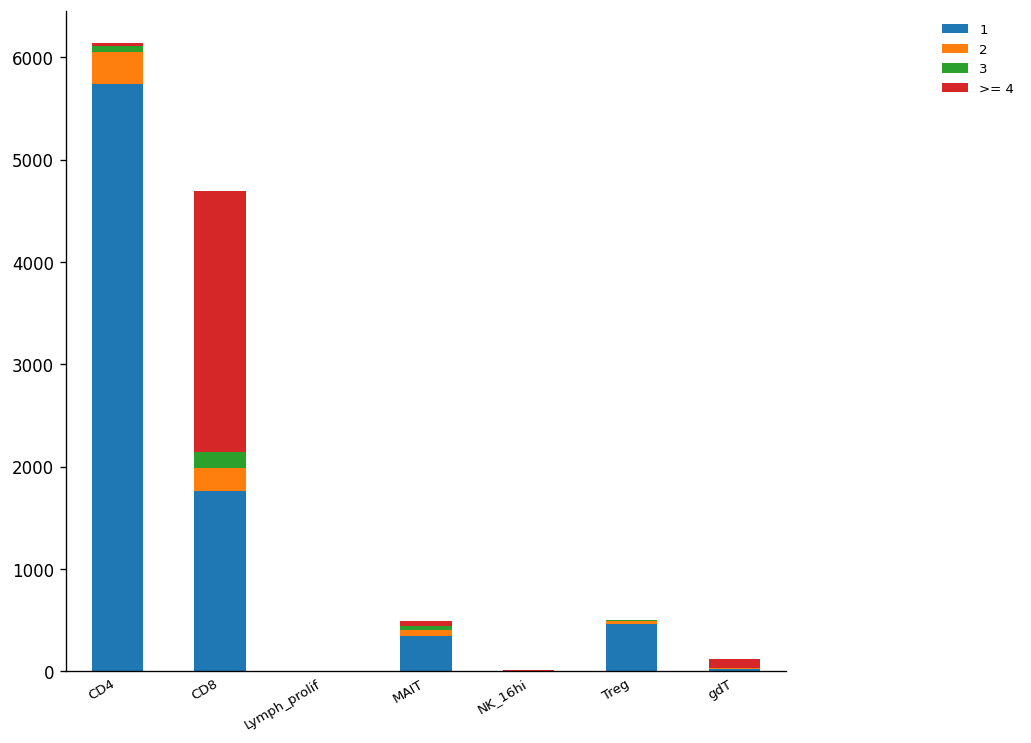

In [26]:
ir.pl.clonal_expansion(
    adata, groupby="initial_clustering", clip_at=4, normalize=False, figsize=[10, 10]
)

<AxesSubplot:>

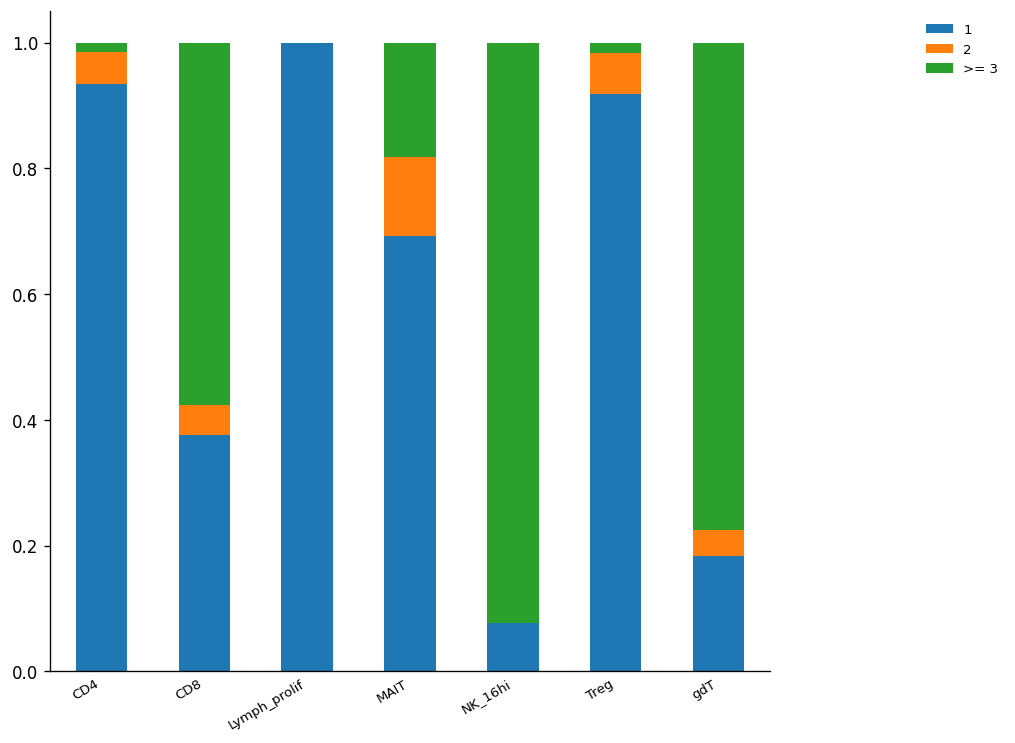

In [28]:
ir.pl.clonal_expansion(adata, "initial_clustering", figsize=[10, 10])

<AxesSubplot:title={'center':'Alpha diversity of clone_id by initial_clustering'}, ylabel='Normalized Shannon Entropy'>

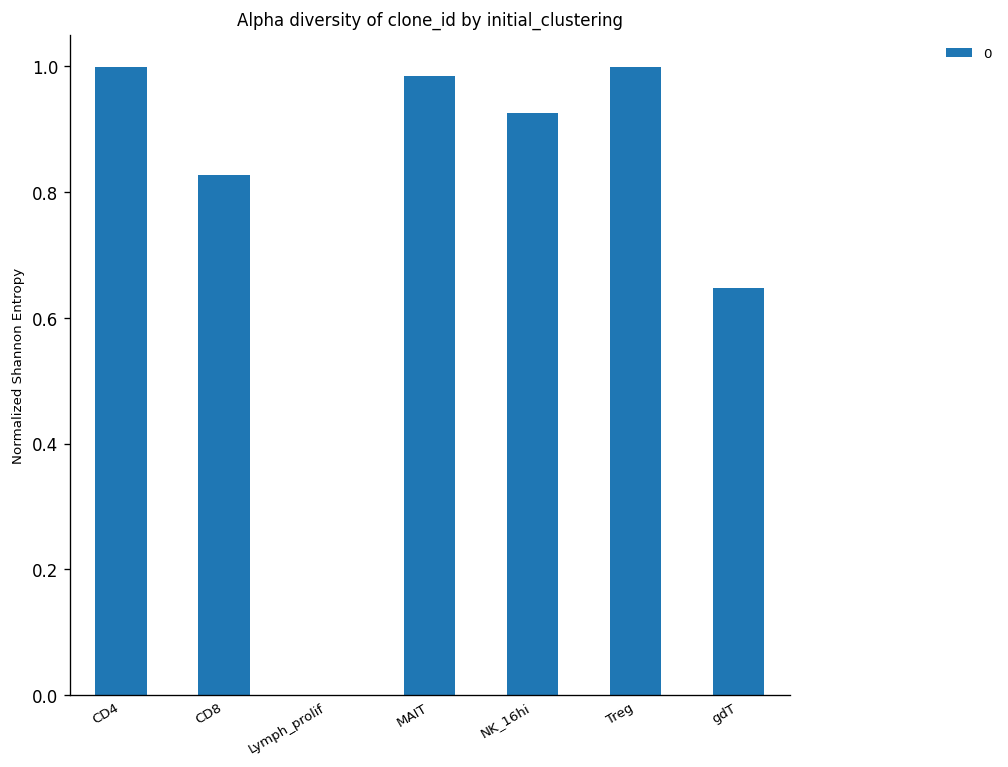

In [30]:
ir.pl.alpha_diversity(adata, groupby="initial_clustering", figsize=[10, 10])

# Clonotype abundance

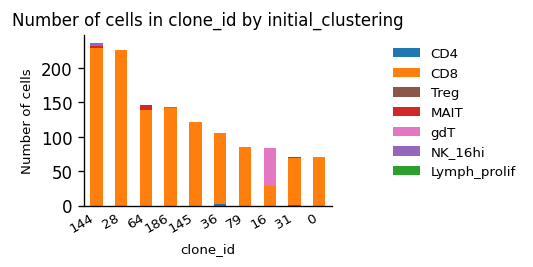

In [109]:
_ = ir.pl.group_abundance(
    adata, groupby="clone_id", target_col="initial_clustering", max_cols=10
)

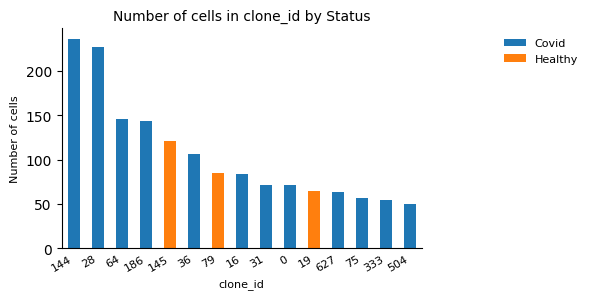

In [110]:
_ = ir.pl.group_abundance(
    adata, groupby="clone_id", target_col="Status", max_cols=15, fig_kws={"dpi": 100}
)

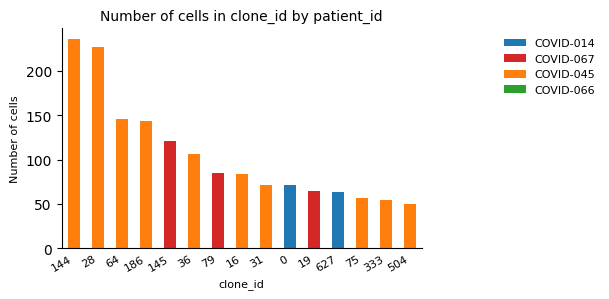

In [50]:
ax = ir.pl.group_abundance(
    adata,
    groupby="clone_id",
    target_col="patient_id",
    max_cols=15,
    fig_kws={"dpi": 100},
)

# Gene usage

<AxesSubplot:title={'center':'Fraction of initial_clustering in each IR_VJ_1_v_call'}, xlabel='IR_VJ_1_v_call', ylabel='Fraction of cells in initial_clustering'>

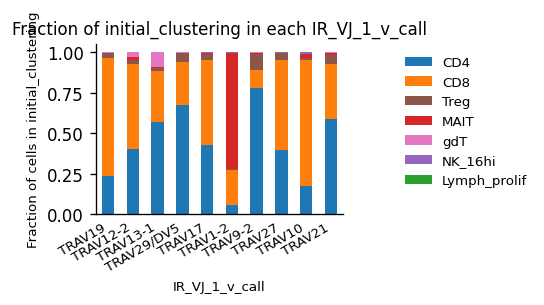

In [53]:
ir.pl.group_abundance(
    adata,
    groupby="IR_VJ_1_v_call",
    target_col="initial_clustering",
    normalize=True,
    max_cols=10,
)

<AxesSubplot:title={'center':'Fraction of IR_VDJ_1_v_call in each initial_clustering'}, xlabel='initial_clustering', ylabel='Fraction of cells in IR_VDJ_1_v_call'>

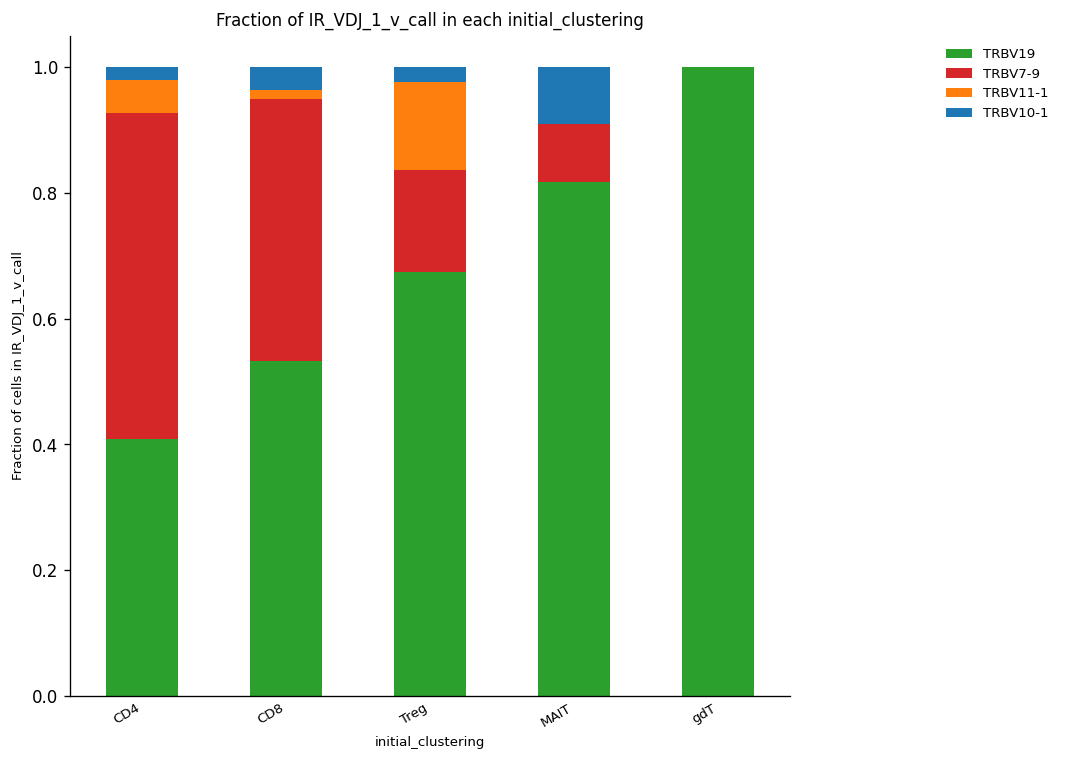

In [73]:
ir.pl.group_abundance(
    adata[
        adata.obs["IR_VDJ_1_v_call"].isin(
            ["TRBV19", "TRBV10-1", "TRBV11-1", "TRBV7-9"]
        ),
        :,
    ],
    groupby="initial_clustering",
    target_col="IR_VDJ_1_v_call",
    normalize=True,
    figsize=[10, 10],
)

<AxesSubplot:>

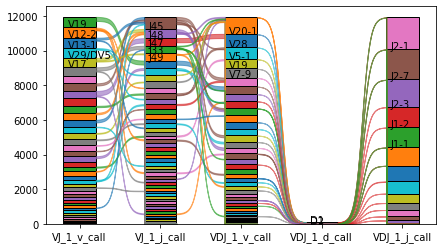

In [74]:
ir.pl.vdj_usage(adata, full_combination=False, max_segments=None, max_ribbons=30)

<AxesSubplot:>

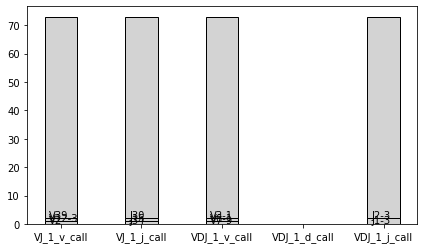

In [79]:
ir.pl.vdj_usage(
    adata[adata.obs["clone_id"].isin(["31", "273", "185"]), :],
    max_ribbons=None,
    max_segments=100,
)

# Spectratype

<AxesSubplot:title={'center':'Spectratype of IR_VJ_1_junction_aa by initial_clustering'}, xlabel='IR_VJ_1_junction_aa length', ylabel='Number of cells'>

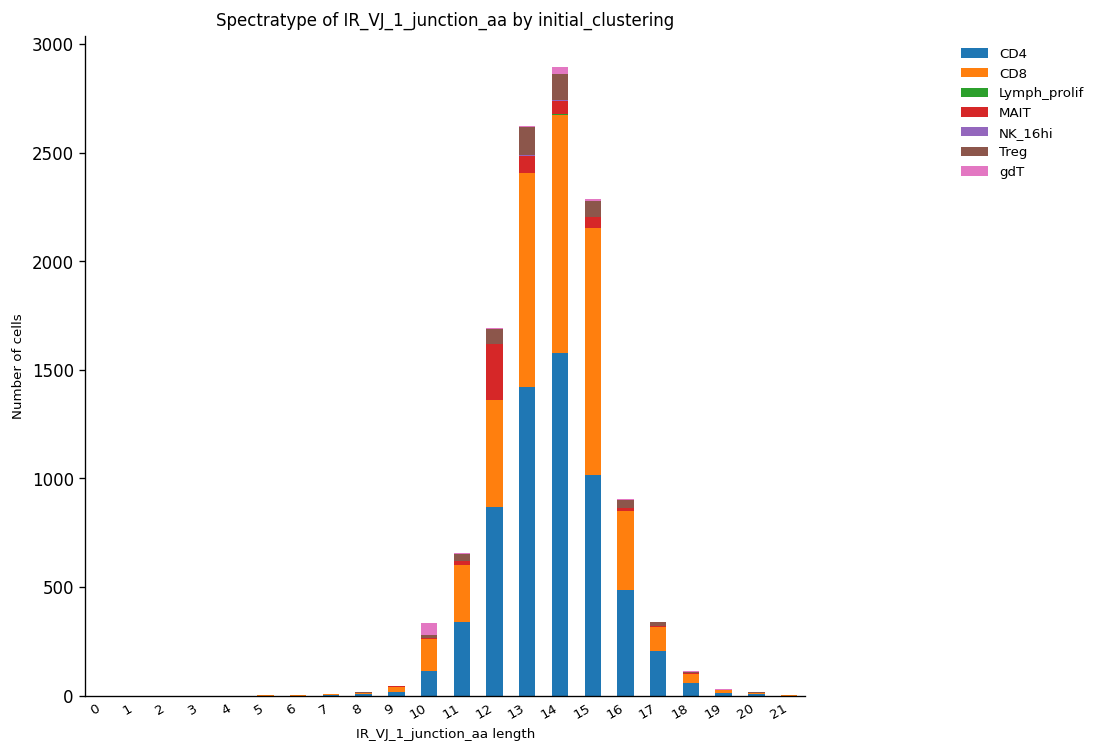

In [80]:
ir.pl.spectratype(
    adata,
    color="initial_clustering",
    viztype="bar",
    fig_kws={"dpi": 120},
    figsize=[10, 10],
)

/home/juan.henao/.local/lib/python3.8/site-packages/scirpy/pl/base.py:262: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(order)


<AxesSubplot:title={'center':'Spectratype of IR_VJ_1_junction_aa by initial_clustering'}, xlabel='IR_VJ_1_junction_aa length'>

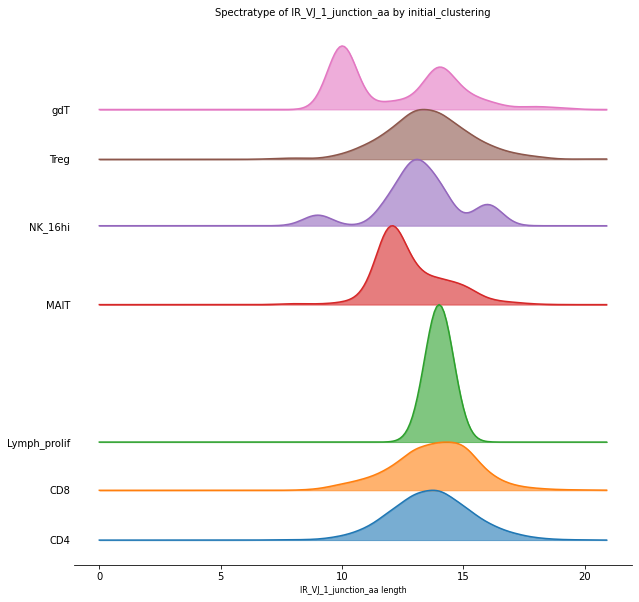

In [81]:
ir.pl.spectratype(
    adata,
    color="initial_clustering",
    viztype="curve",
    curve_layout="shifted",
    fig_kws={"figsize": [10, 10]},
    kde_kws={"kde_norm": False},
)

/home/juan.henao/.local/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


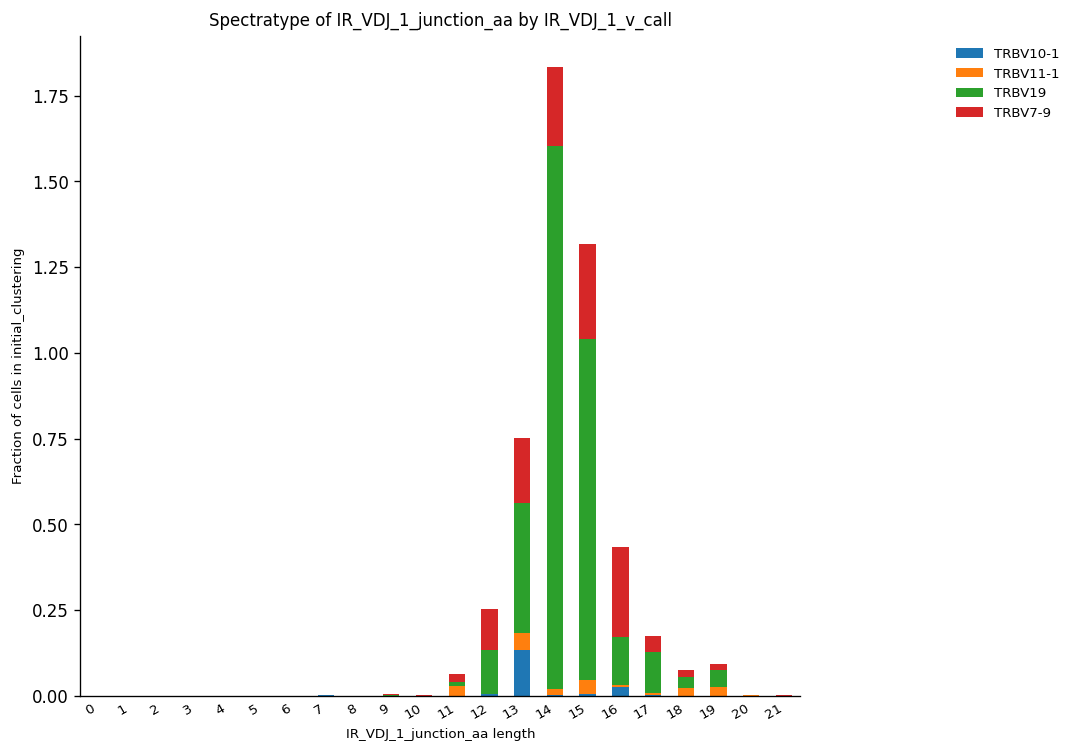

In [112]:
_ = ir.pl.spectratype(
    adata[
        adata.obs["IR_VDJ_1_v_call"].isin(
            ["TRBV19", "TRBV10-1", "TRBV11-1", "TRBV7-9"]
        ),
        :,
    ],
    cdr3_col="IR_VDJ_1_junction_aa",
    color="IR_VDJ_1_v_call",
    normalize="initial_clustering",
    fig_kws={"dpi": 120},
    figsize=[10, 10],
)

# Repertoire comparison

In [87]:
df, dst, lk = ir.tl.repertoire_overlap(adata, "patient_id", inplace=False)

In [88]:
df

clone_id,0,1,2,3,4,5,6,7,8,9,...,8848,8849,8850,8851,8852,8853,8854,8855,8856,8857
patient_id,,,,,,,,,,,,,,,,,,,,,
COVID-014,71.0,0.0,0.0,1.0,4.0,0.0,0.0,2.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
COVID-045,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
COVID-066,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
COVID-067,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [89]:
dst

array([1., 1., 1., 1., 1., 1.])

In [90]:
lk

array([[0., 1., 1., 2.],
       [2., 4., 1., 3.],
       [3., 5., 1., 4.]])

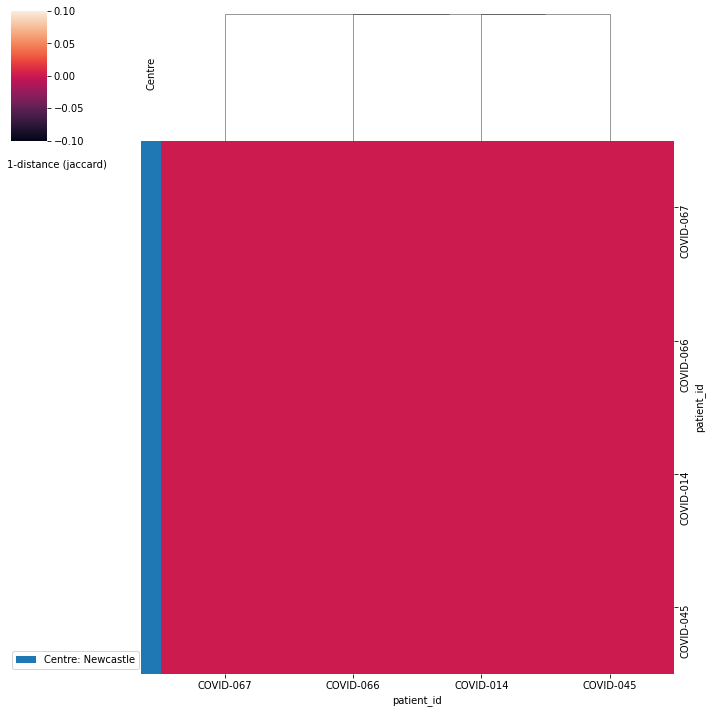

In [92]:
ir.pl.repertoire_overlap(adata, "patient_id", heatmap_cats=["Centre"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


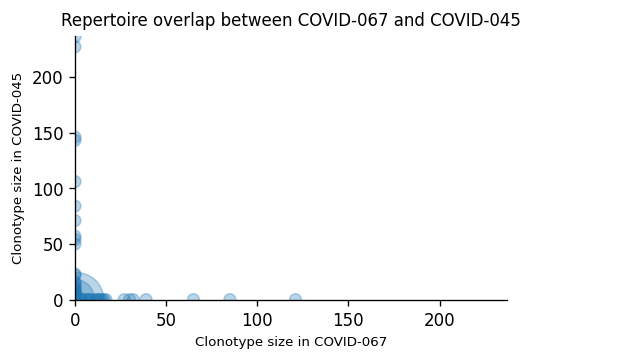

In [111]:
_ = ir.pl.repertoire_overlap(
    adata, "patient_id", pair_to_plot=["COVID-067", "COVID-045"], fig_kws={"dpi": 120}
)

In [105]:
ir.pl.clonotype_imbalance(
    adata,
    replicate_col="patient_id",
    groupby="initial_clustering",
    case_label="CD8",
    control_label="CD4",
    plot_type="strip",
)

KeyError: 'initial_clustering'

In [ ]:
ir.pl.clonotype_imbalance(
    adata,
    replicate_col="sample",
    groupby="type",
    case_label="NOD",
    control_label="BulbC",
    plot_type="volcano",
    fig_kws={"dpi": 120},
)

In [95]:
adata.obs["Status"]

cell_id
AAACCTGAGAAACCTA-MH9179824      Covid
AAACCTGAGAACTCGG-MH8919329      Covid
AAACCTGAGACTTGAA-MH8919176    Healthy
AAACCTGAGAGTAATC-MH9179824      Covid
AAACCTGAGAGTGAGA-MH9179824      Covid
                               ...   
TTTGTCATCAGTGCAT-MH8919332    Healthy
TTTGTCATCAGTGTTG-MH8919332    Healthy
TTTGTCATCCGCAAGC-MH8919176    Healthy
TTTGTCATCGCCAAAT-MH8919329      Covid
TTTGTCATCTTTAGTC-MH8919332    Healthy
Name: Status, Length: 11960, dtype: category
Categories (2, object): ['Covid', 'Healthy']